*Автор: Сергий Ярыгин*

В этом ноутбуке проводится первичный анализ датасета с целью выделения целевых классов для модели.

Рассматриваются разные виды тегов статей на хабре, проводится их анализ, а так же проводится кластеризация хабов с целью уменьшения количества различных классов.

In [1]:
import random

import datasets
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

random.seed(42)

In [2]:
from habr_article_analyzer import data, data_loader
from habr_article_analyzer.data import DEFAULT_FULL_PATH

In [3]:
data.download_dataset(DEFAULT_FULL_PATH)

In [4]:
dataset = data.load_dataset_from_zst(rows_num=10000)

Reading records: 9999it [00:04, 2240.56it/s]


In [5]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 22 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   id               10000 non-null  int64 
 1   language         10000 non-null  object
 2   url              10000 non-null  object
 3   text_markdown    10000 non-null  object
 4   text_html        10000 non-null  object
 5   lead_markdown    9993 non-null   object
 6   lead_html        10000 non-null  object
 7   type             10000 non-null  object
 8   labels           10000 non-null  object
 9   original_author  973 non-null    object
 10  original_url     973 non-null    object
 11  time_published   10000 non-null  int64 
 12  author           10000 non-null  object
 13  title            10000 non-null  object
 14  statistics       10000 non-null  object
 15  hubs             10000 non-null  object
 16  flows            10000 non-null  object
 17  tags             10000 non-null 

Для полной выгрузки выберем тлоько необходимые колонки (иначе мне не хватит RAM), будем выгружать датасет батчами, оставлять у них нужные колонки и мержить в один `pd.DataFrame`: 

In [6]:
columns_to_load = ["id", "title", "text_markdown", "hubs", "labels", "tags", "flows"]

dataset = data_loader.HabrDataset(
    path=DEFAULT_FULL_PATH, columns=columns_to_load, batch_size=50_000
)

all_batches = []
for batch_df in dataset:
    all_batches.append(batch_df)

full_df = pd.concat(all_batches, ignore_index=True)
full_df.head()

Reading dataset: 302049it [01:48, 2773.30it/s]


,id,text_markdown,labels,title,hubs,flows,tags
0,12730,"Абитуриенты, поступающие в Университет Чикаго,...",[],Хочешь в университет — сделай презентацию,[itcompanies],[popsci],"[PowerPoint, презентация, абитуриенты, институ..."
1,558542,Иногда бывает нужно размыть задний план на экр...,[],"То, чего нам так не хватало: Render Effect в A...","[simbirsoft, mobile_dev, android_dev, apps_des...","[develop, design]","[android, android 12, render effect, blur, col..."
2,141150,Wikimedia Foundation собирается запустить сайт...,[],Wikidata: первый новый проект Wikimedia Founda...,"[microformats, sw]",[develop],"[Wikidata, Wikimedia Foundation, искусственный..."
3,530546,"Привет! Продолжая традицию, собрали «классичес...",[],(не) Безопасный дайджест: сливы COVID-пациенто...,"[searchinform, infosecurity]",[develop],"[утечки информации, информационная безопасност..."
4,598357,Напомню: когда мы решили ввести тарифы на VDS ...,[],Все врут-2: чем закончился детектив про медлен...,"[ruvds, s_admin, dwh, pm, hardware]","[management, admin, popsci]","[сервер, NVMe-сервер, конфигурация, хостинг, т..."


In [7]:
full_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 302049 entries, 0 to 302048
Data columns (total 7 columns):
 #   Column         Non-Null Count   Dtype 
---  ------         --------------   ----- 
 0   id             302049 non-null  int64 
 1   text_markdown  302049 non-null  object
 2   labels         302049 non-null  object
 3   title          302049 non-null  object
 4   hubs           302049 non-null  object
 5   flows          302049 non-null  object
 6   tags           302049 non-null  object
dtypes: int64(1), object(6)
memory usage: 16.1+ MB


In [8]:
full_df.describe()

,id
count,302049.000000
mean,324681.610898
std,210431.252045
min,1.000000
25%,131406.000000
50%,318104.000000
75%,498800.000000
max,716000.000000


In [9]:
from habr_article_analyzer.targets import Target

hubs = Target(full_df, "hubs", sparse=True)
flows = Target(full_df, "flows")
tags = Target(full_df, "tags", sparse=True)
labels = Target(full_df, "labels")

In [10]:
def fix_len(word: str, n=10):
    if len(word) >= n + 3:
        return word[:n] + "..."
    else:
        return word + " " * (n - (len(word)))


def info(self: Target, top=20):
    print(f"Target: {self.column_name}")
    print(f"There are {len(self.labels)} unique labels")
    sorted_by_size = [
        (label, size)
        for label, size in sorted(
            zip(self.labels, self.get_sizes()), key=lambda x: x[1], reverse=True
        )
    ]

    def print_list(sorted_group):
        for i, (label, size) in enumerate(sorted_group):
            coverage = size / len(full_df)
            print(f"{i}:\t{fix_len(label)}\t{size}\t{coverage*100:.2f}%")

    if len(self.labels) > top * 2:
        print(f"Top {top} labels by their size:")
        print_list(sorted_by_size[:top])
        print(f"Tail {top} labels by their size:")
        print_list(sorted_by_size[-top:])
    else:
        print(f"Labels by their size:")
        print_list(sorted_by_size)

    print(f"Sum coverage by top-N labels:")
    percent_to_cover = [50, 75, 80, 90, 95, 99]
    l, r = 0, len(self)
    for percent in percent_to_cover:
        r = len(self)
        while l < r:
            m = (l + r) // 2
            coverage = self.get_coverage([label for label, _ in sorted_by_size[:m]])
            if coverage * 100 <= percent:
                l = m + 1
            else:
                r = m
        print(f"Top-{m} labels cover ~{percent}%")

In [11]:
info(hubs)

Target: hubs
There are 2558 unique labels
Top 20 labels by their size:
0:	closet    	27484	9.10%
1:	itcompanies	20675	6.84%
2:	infosecurity	17700	5.86%
3:	programming	17303	5.73%
4:	webdev    	14389	4.76%
5:	popular_sc...	14360	4.75%
6:	javascript	8668	2.87%
7:	gadgets   	8666	2.87%
8:	finance   	7307	2.42%
9:	business-l...	7285	2.41%
10:	career    	7219	2.39%
11:	it-infrast...	7097	2.35%
12:	hardware  	6646	2.20%
13:	sys_admin 	6488	2.15%
14:	gamedev   	6465	2.14%
15:	python    	6228	2.06%
16:	open_source	6156	2.04%
17:	mobile_dev	6122	2.03%
18:	DIY       	6109	2.02%
19:	space     	6004	1.99%
Tail 20 labels by their size:
0:	unitmobile	1	0.00%
1:	uplift    	1	0.00%
2:	upsale    	1	0.00%
3:	vamshop   	1	0.00%
4:	video360pr...	1	0.00%
5:	videointel...	1	0.00%
6:	viknano2016	1	0.00%
7:	vimcom    	1	0.00%
8:	vkrugudruzei	1	0.00%
9:	vraschete 	1	0.00%
10:	vulners   	1	0.00%
11:	webprice  	1	0.00%
12:	wellpay   	1	0.00%
13:	westconcept	1	0.00%
14:	wikify    	1	0.00%
15:	wizee     	1	0.00%
1

In [12]:
info(flows)

Target: flows
There are 6 unique labels
Labels by their size:
0:	develop   	132639	43.91%
1:	popsci    	122269	40.48%
2:	management	48557	16.08%
3:	admin     	32120	10.63%
4:	marketing 	15970	5.29%
5:	design    	10815	3.58%
Sum coverage by top-N labels:
Top-2 labels cover ~50%
Top-2 labels cover ~75%
Top-2 labels cover ~80%
Top-5 labels cover ~90%
Top-5 labels cover ~95%
Top-5 labels cover ~99%


In [13]:
info(tags)

Target: tags
There are 244777 unique labels
Top 20 labels by their size:
0:	javascript	5676	1.88%
1:	python    	4800	1.59%
2:	android   	4794	1.59%
3:	google    	4514	1.49%
4:	программир...	4144	1.37%
5:	linux     	4118	1.36%
6:	разработка	4089	1.35%
7:	java      	3850	1.27%
8:	php       	3601	1.19%
9:	apple     	3559	1.18%
10:	microsoft 	3523	1.17%
11:	информацио...	3141	1.04%
12:	игры      	3108	1.03%
13:	Google    	2857	0.95%
14:	open source	2510	0.83%
15:	стартапы  	2460	0.81%
16:	безопасность	2363	0.78%
17:	машинное о...	2360	0.78%
18:	Microsoft 	2336	0.77%
19:	социальные...	2273	0.75%
Tail 20 labels by their size:
0:	‎mytracker‬	1	0.00%
1:	“Morecard”	1	0.00%
2:	“Байкал-Т1”	1	0.00%
3:	€1.1 мрлд 	1	0.00%
4:	№149-ФЗ Об...	1	0.00%
5:	№398-ФЗ   	1	0.00%
6:	№89417-6  	1	0.00%
7:	№office st...	1	0.00%
8:	™         	1	0.00%
9:	↓↓→←□     	1	0.00%
10:	★         	1	0.00%
11:	♥         	1	0.00%
12:	❨╯°□°❩╯︵┻━┻	1	0.00%
13:	内森·菲利安    	1	0.00%
14:	华为， 你认为这个怎...	1	0.00%
15:	喬斯·溫登     	1	0.00%
16

In [14]:
info(labels)

Target: labels
There are 11 unique labels
Labels by their size:
0:	translation	27870	9.23%
1:	sandbox   	23328	7.72%
2:	recovery  	5994	1.98%
3:	technotext...	615	0.20%
4:	technotext...	557	0.18%
5:	technotext...	410	0.14%
6:	seasonJava...	48	0.02%
7:	megapostType	35	0.01%
8:	seasonDm2022	23	0.01%
9:	seasonKube...	19	0.01%
10:	habrItMedia	5	0.00%
Sum coverage by top-N labels:
Top-10 labels cover ~50%
Top-10 labels cover ~75%
Top-10 labels cover ~80%
Top-10 labels cover ~90%
Top-10 labels cover ~95%
Top-10 labels cover ~99%


### Выбор типа метки

Выше приведены сводки информации по каждому из четырех видов текстовых меток: `['hubs', 'tags', 'labels', 'flows']`. 
Видно, что `['hubs', 'tags']` - метки с большим количеством классов относящихся к содержанию текста, а `['labels', 'flows']` - скорее технические метки с маленьким количеством классов. Хотя `flows` отражает некоторую категорию текста, эта категория слишком абстрактна (sci-fi, develop) для нашей задачи.

Поэтому, в контексте нашей задачи, интересны именно метки `hubs` и `tags`. 
Видно, что для покрытия более 95% примеров в датасете, нужно будет использовать примерно 200 и 2000 классов из каждого типа меток. 
Это звучит как слишком большое число меток, при этом не достигается полного покрытия. 

Далее посмотрим на примеры, которые не покрыты этим множествами меток, а так же рассмотрим рандомные примеры из каждого из этих множеств.

In [15]:
def labels_sample(self: Target, n_samples: int = 20):
    print(f"Random samples for '{self.column_name}':")
    print("\n".join(random.sample(self.labels, n_samples)))

In [16]:
labels_sample(hubs)

Random samples for 'hubs':
copyright
advantech
it_testing
icon_partners
greasemonkey
desktop_environment
codeorchestra
telecitygroup
celecom
vivaldi
pozvonim
alldigital
alfarobotics
cleantalk
golovanov_net
hetmansoftware
smmreact
webmoney
afidistribution
trendmicro


In [17]:
labels_sample(tags)

Random samples for 'tags':
TorrentTV
майкл делл
дуб
космический проект
Пульс
realtor2.ru
YAMAL DEV
startup addventure
барьеры памяти
design tokens
проприетарное по
стратегия развития автопрома
2 инсайта
ого
продажа лекарств
Pyhon
контрпро
ress
irm
dependentObservable


Видно, что среди тегов встречаются как на русском языке, так и на английском. Проверим есть ли дубли на нескольких примерах.

In [18]:
pairs = [
    ["deep learning", "нейронные сети"],
    ["нейросети", "нейронные сети"],
    ["deep learning", "глубокое обучение"],
    ["develop", "разработка"],
    ["network", "сеть"],
    ["AI", "ИИ"],
    ["machine learning", "машинное обучение"],
]

for pair in pairs:
    en, ru = pair
    try:
        en_cov = tags.get_coverage(en) * 100
        ru_cov = tags.get_coverage(ru) * 100
        both_cov = tags.get_coverage(pair) * 100
        print(f"For pair: {pair}")
        print(f"{fix_len(en)}\t{en_cov}")
        print(f"{fix_len(ru)}\t{ru_cov}")
        print(f"{fix_len('Both')}\t{both_cov}")
    except Exception as e:
        print("Got an exception: {}".format(e))

For pair: ['deep learning', 'нейронные сети']
deep learn...	0.15063781042148788
нейронные ...	0.25161480422050725
Both      	0.3823882879930077
For pair: ['нейросети', 'нейронные сети']
нейросети 	0.2559187416611212
нейронные ...	0.25161480422050725
Both      	0.4843584981244765
For pair: ['deep learning', 'глубокое обучение']
deep learn...	0.15063781042148788
глубокое о...	0.07515336915533571
Both      	0.20460256448457037
For pair: ['develop', 'разработка']
develop   	0.0029796489973481126
разработка	1.3537538611284923
Both      	1.3567335101258404
For pair: ['network', 'сеть']
network   	0.05197832139818374
сеть      	0.09402447947187377
Both      	0.14401636820515876
For pair: ['AI', 'ИИ']
AI        	0.07813301815268384
ИИ        	0.13772599809964609
Both      	0.19731897804660833
For pair: ['machine learning', 'машинное обучение']
machine le...	0.3734493410009634
машинное о...	0.7813301815268384
Both      	1.0468500144016368


Видно, что теги не структурированы - встречаются дубли как на одном (`нейросети` - `нейронные сети`), так и на разных языках (`machine learning` - `машинное обучение`). В таком виде эти данные не очень хорошо подходят для обучения модели, так как эти классы не будут отличаться по смыслу, при этом будут разными классами, что усложняет обучение.

В `tags` встречаются довольно разнообразные лейблы. Я попробовал написать статью (тестовую) на habr.com для того, чтобы разобраться, как проставляются `hubs` (хабы) и `tags` (ключевые слова или теги). 

Теги можно выбрать из выпадающего списка, а можно - добавить свой новый тег. 
Хабы же можно выбирать из большого, но фиксированного списка.

В таком случае для обучения классификатора лучше подходят хабы. Но при этом их все ещё слишком много. 

Одним из решений в таком случае было бы оставить топ-100/топ-200 хабов, обеспечивающие наибольшее покрытие статей. 
Но я хочу рассмаотреть альтернативный способ, позволяющий не жертвовать покрытием совсем - кластеризовать все хабы на N кластеров и выбрать эти группы в качестве таргетов для модели. 

В данном случае у нас нет готовых (или зафиксированных) эмбеддингов для кластеризации, что не позволяет нам использовать большинство метрик кластеризации для сравнения качества полученных групп лейблов. 

Поэтому я предлагаю сделать довольно неприятную, зато честную работу: 
- разметить 40 пар лейблов бинарно: должны они попадать в один класс или нет
- домайнить позитивов в эту разметку, посредством тщательного анализа лейблов

In [19]:
import json

sample1, sample2 = random.sample(hubs.labels, 40), random.sample(hubs.labels, 40)

print(json.dumps(list(zip(sample1, sample2)), indent=4))

[
    [
        "dsec",
        "epayservice"
    ],
    [
        "gitfund",
        "syncdriver"
    ],
    [
        "megalenta",
        "icl_services"
    ],
    [
        "codeigniter",
        "efo"
    ],
    [
        "citrix",
        "rocketcallback"
    ],
    [
        "nubes",
        "ntc-vulkan"
    ],
    [
        "cloud_services",
        "iridiummobile"
    ],
    [
        "myasterisk",
        "toshiba"
    ],
    [
        "misis",
        "google_cloud_vision_api"
    ],
    [
        "webprojects",
        "magnit"
    ],
    [
        "intersystems",
        "aws"
    ],
    [
        "apps_design",
        "hamstermarketplace"
    ],
    [
        "ritm-z",
        "allmemory"
    ],
    [
        "t1consulting",
        "liveexpertru"
    ],
    [
        "d-lera",
        "parallel_programming"
    ],
    [
        "npoechelon",
        "iplexgroup"
    ],
    [
        "businessstudio",
        "bigdata"
    ],
    [
        "tinkoff",
        "genue"
    

После такой небольшой разметки, хочется выделить кластера компаний (и вероятно, отдельно, компаний занимающихся облачными решениями), геймдев и приложения для разработки. 


In [20]:
from habr_article_analyzer.settings import settings

with open(settings.data_dir / 'markup/clusters.json', '+r') as file:
    markup = json.load(file)

print(markup)

[['branding', 'business_models', 1], ['business-laws', 'business_models', 1], ['research', 'patents', 1], ['skyeng', 'learning_languages', 1], ['sberbank', 'vtb', 1], ['study', 'netologyru', 1], ['DIY', 'raspberrypi', 1], ['html5', 'javascript', 1], ['cpp', 'c', 1], ['machine_learning', 'natural_language_processing', 1], ['mongodb', 'postgresql', 1], ['microformats', 'edge', 0], ['masterkit', 'medgadgets', 1], ['asus', 'social_networks', 0], ['skyeng', 'cpu', 0], ['alconost', 'metrotek', 0.5], ['vertdider', 'wunderfund', 0.5], ['biology', 'beeline', 0], ['cloudsnn', 'virtualization', 0.5], ['plarium', 'pixonic', 1], ['compilers', 'gadgets', 0], ['study', 'unisender', 0], ['refactoring', 'postgresql', 0], ['itcompanies', 'pay_system', 0.5], ['owasp', 'cybersport', 0], ['antikvariat', 'cloudsnn', 0], ['image_processing', 'html5', 0], ['ie', 'complete_code', 0], ['learning_languages', 'naumen', 0], ['mongodb', 'sport_programming', 0], ['e-legion', 'yandex_api', 0], ['network_standarts', '

In [21]:
positive = 0
negative = 0
halfs = 0

for pair in markup:
    if len(pair) != 3:
        continue
    l, r, score = pair
    positive += int(score == 1)
    negative += int(score == 0)
    halfs += int(score == 0.5)

print(f"Positives: {positive}")
print(f"Negatives: {negative}")
print(f"Halfs: {halfs}")

Positives: 26
Negatives: 79
Halfs: 7


Это не много, но это честная работа! (асессором)

In [46]:
def measure_clusterization(
    markup: list[list], clusters: dict[int : list[str]], target: Target = hubs, texts: list[str] = hubs.labels
) -> dict[str:float]:
    markup = list(filter(lambda x: len(x) == 3 and x[2] != 0.5, markup))
    inverse_clusters = dict(
        [(value, key) for key, values in clusters.items() for value in values]
    )
    TP, FP, TN, FN = 0, 0, 0, 0
    FPs = []
    FNs = []
    for pair in markup:
        l, r, mark = pair
        if l not in texts or r not in texts:
            continue
        l_id, r_id = inverse_clusters[l], inverse_clusters[r]

        if mark == 1 and l_id == r_id:
            TP += 1
        elif mark == 1 and l_id != r_id:
            FN += 1
            FNs.append((l, r))
        elif mark == 0 and l_id == r_id:
            FP += 1
            FPs.append((l, r))
        elif mark == 0 and l_id != r_id:
            TN += 1
    
    coverages = []

    for key, values in clusters.items():
        coverages.append(target.get_coverage(values))

    cov = np.array(coverages)

    return {
        "TP": TP,
        "FP": FP,
        "FN": FN,
        "TN": TN,
        "accuracy": (TP + TN) / len(markup),
        "false_positives": FPs,
        "false_negatives": FNs,
        "mean_cov_per_cluster": cov.mean(),
        "cov_dispersion_per_cluster": cov.var(),
        "coverages": coverages
    }

In [23]:
from collections import defaultdict


def get_clusters(clusters: np.ndarray, X: list[str]) -> dict[int, list[str]]:
    result = defaultdict(list)
    for key, value in zip(clusters, X):
        result[int(key)].append(value)
    return result

Далее я буду пробовать различные способы кластеризации лейблов.
Кластеризация состоит из двух частей:
Embedder + Clusterization algorithm

В качестве алгоритма кластеризации возьмем KMeans. 
А для эмбеддера рассмотрим несколько разных подходов:
1. Эмбеддинги MiniLM 
2. Instructor (модель, у которой эмбеддинги конфигугрируются с помощью промпта) (paper: https://arxiv.org/abs/2212.09741)

Так же для каждой модели подберем оптимальное множество кластеров (от 20 до 100).

In [24]:
from sklearn.cluster import KMeans
from huggingface_hub.utils import disable_progress_bars
from sentence_transformers import SentenceTransformer
from InstructorEmbedding import INSTRUCTOR
from torch.cuda import is_available
from collections import defaultdict

disable_progress_bars()

device = 'cuda' if is_available() else 'cpu'
print(device)

cuda


In [44]:
def compare_clusterings(
    embeddings: dict[str, np.ndarray],
    clusterizations: dict[str, KMeans],
    texts: list[str],
    **kwargs
) -> dict[str, dict]:
    result = {
        'accuracy' : {},
        'coverage_mean': {},
        'coverage_variance': {},
        'clusters' : {}
    }
    for embeddings_name, embeds in embeddings.items():
        result['accuracy'][embeddings_name] = {}
        result['coverage_mean'][embeddings_name] = {}
        result['coverage_variance'][embeddings_name] = {}
        result['clusters'][embeddings_name] = {}
        for clusters_name, clusters in clusterizations.items():
            clusters_res = get_clusters(clusters.fit_predict(
                embeds, **kwargs
            ), texts)

            metrics = measure_clusterization(markup, clusters_res, texts=texts)

            result['accuracy'][embeddings_name][clusters_name] = metrics['accuracy']
            result['coverage_mean'][embeddings_name][clusters_name] = metrics['mean_cov_per_cluster']
            result['coverage_variance'][embeddings_name][clusters_name] = metrics['cov_dispersion_per_cluster']
            result['clusters'][embeddings_name][clusters_name] = clusters_res

    return result            

In [26]:
embeddings = {}

In [27]:
small_llm = SentenceTransformer("sentence-transformers/paraphrase-multilingual-MiniLM-L12-v2").to(device)

In [28]:
instructor_llm = INSTRUCTOR("hkunlp/instructor-large").to(device)

No sentence-transformers model found with name hkunlp/instructor-large. Creating a new one with mean pooling.


In [29]:
embeddings["small_llm_hubs"] = small_llm.encode(hubs.labels)

In [30]:
empty_instruction = [["", label] for label in hubs.labels]
embeddings["instructor_llm_hubs"] = instructor_llm.encode(empty_instruction)

`SentenceTransformer._target_device` has been deprecated, please use `SentenceTransformer.device` instead.


In [ ]:
instruction_1 = [["Represent the Programming Hub category for clustering:", label] for label in hubs.labels]
instruction_2 = [["Represent the Programming Hub category for company or technology clustering:", label] for label in hubs.labels]
instruction_3 = [["Represent the Programming Hub category for company or technology or activity clustering:", label] for label in hubs.labels]
instruction_4 = [["Represent the Programming Hub category for company or technology or profession clustering:", label] for label in hubs.labels]

embeddings["instructor_llm_instruction_1_hubs"] = instructor_llm.encode(instruction_1)
embeddings["instructor_llm_instruction_2_hubs"] = instructor_llm.encode(instruction_2)
embeddings["instructor_llm_instruction_3_hubs"] = instructor_llm.encode(instruction_3)
embeddings["instructor_llm_instruction_4_hubs"] = instructor_llm.encode(instruction_4)

`SentenceTransformer._target_device` has been deprecated, please use `SentenceTransformer.device` instead.
`SentenceTransformer._target_device` has been deprecated, please use `SentenceTransformer.device` instead.
`SentenceTransformer._target_device` has been deprecated, please use `SentenceTransformer.device` instead.
`SentenceTransformer._target_device` has been deprecated, please use `SentenceTransformer.device` instead.


Скорее всего, текстовым моделям будет мало контекста из одного-двух слов (часто аббревиатур), поэтому к самим хабам мы добавим самые важные для них слова из текстов статей (отобраны по топу tf-idf).

In [31]:
hubs_top_words = hubs.get_top_words_per_label("text_markdown")

In [32]:
for hub in ['cpp', 'lua', 'machine_learning', 'yandex', 'sberbank']:
    print(f"top words for {hub}: {hubs_top_words[hub]}")

top words for cpp: [('typename', 68.56698608398438), ('nullptr', 64.1811752319336), ('std', 62.06353759765625), ('endl', 62.02785873413086), ('cout', 59.51510238647461), ('size_t', 48.453330993652344), ('cpp', 48.36735153198242), ('clang', 45.045719146728516), ('boost', 42.23896408081055), ('cmake', 39.213294982910156)]
top words for lua: [('lua', 470.2598571777344), ('tarantool', 182.81861877441406), ('local', 62.38478469848633), ('nil', 39.27334213256836), ('end', 36.40678405761719), ('then', 35.723548889160156), ('websocket', 23.55497932434082), ('require', 23.21576499938965), ('stats', 22.978740692138672), ('graphics', 21.74737548828125)]
top words for machine_learning: [('keras', 41.224647521972656), ('датасет', 34.62981033325195), ('tensorflow', 34.4794921875), ('loss', 34.19388961791992), ('train', 32.76811981201172), ('tf', 29.966026306152344), ('ml', 28.15020179748535), ('нейронной', 27.478361129760742), ('нейронных', 24.973222732543945), ('нейронные', 24.480758666992188)]
top

In [33]:
def build_text(
    hub: str,
    top_words: dict[str, tuple[str, float]],
    instruction: str | None = None
) -> str | list[str]:
    if instruction is None:
        return hub + " " + " ".join([x for x, _ in top_words[hub]])
    else:
        return [instruction, build_text(hub, top_words, None)]


In [34]:
print(f"text for cpp: {build_text('cpp', hubs_top_words)}")
print(f"text for cpp with instruction: {build_text('cpp', hubs_top_words, 'Very important instruction')}")

text for cpp: cpp typename nullptr std endl cout size_t cpp clang boost cmake
text for cpp with instruction: ['Very important instruction', 'cpp typename nullptr std endl cout size_t cpp clang boost cmake']


In [82]:
embeddings["small_llm_hubs_with_top_words"] = small_llm.encode([build_text(label, hubs_top_words) for label in hubs.labels])

In [83]:
empty_instruction_top_words = [build_text(label, hubs_top_words, "") for label in hubs.labels]
embeddings["instructor_llm_hubs_with_top_words"] = instructor_llm.encode(empty_instruction_top_words)

`SentenceTransformer._target_device` has been deprecated, please use `SentenceTransformer.device` instead.


In [84]:
instruction_1_top_words = [build_text(label, hubs_top_words, "Represent the Programming Hub category for clustering:") for label in hubs.labels]
instruction_2_top_words = [build_text(label, hubs_top_words, "Represent the Programming Hub category for company or technology clustering:") for label in hubs.labels]
instruction_3_top_words = [build_text(label, hubs_top_words, "Represent the Programming Hub category for company or technology or activity clustering:") for label in hubs.labels]
instruction_4_top_words = [build_text(label, hubs_top_words, "Represent the Programming Hub category for company or technology or profession clustering:") for label in hubs.labels]

embeddings["instructor_llm_instruction_1_hubs_with_top_words"] = instructor_llm.encode(instruction_1_top_words)
embeddings["instructor_llm_instruction_2_hubs_with_top_words"] = instructor_llm.encode(instruction_2_top_words)
embeddings["instructor_llm_instruction_3_hubs_with_top_words"] = instructor_llm.encode(instruction_3_top_words)
embeddings["instructor_llm_instruction_4_hubs_with_top_words"] = instructor_llm.encode(instruction_4_top_words)
embeddings["instructor_llm_instruction_4_hubs_with_top_words"] = instructor_llm.encode(instruction_4_top_words)

`SentenceTransformer._target_device` has been deprecated, please use `SentenceTransformer.device` instead.
`SentenceTransformer._target_device` has been deprecated, please use `SentenceTransformer.device` instead.
`SentenceTransformer._target_device` has been deprecated, please use `SentenceTransformer.device` instead.
`SentenceTransformer._target_device` has been deprecated, please use `SentenceTransformer.device` instead.
`SentenceTransformer._target_device` has been deprecated, please use `SentenceTransformer.device` instead.


In [85]:
clusterizations = dict([
   ('kmeans_' + str(i), KMeans(n_clusters=i, random_state=42)) for i in [10, 25, 50, 75, 100]
])

In [86]:
compare_result = compare_clusterings(embeddings, clusterizations, hubs.labels)
print(compare_result['accuracy'])

{'small_llm_hubs': {'kmeans_10': 0.7142857142857143, 'kmeans_25': 0.7714285714285715, 'kmeans_50': 0.7714285714285715, 'kmeans_75': 0.7523809523809524, 'kmeans_100': 0.7714285714285715}, 'instructor_llm_hubs': {'kmeans_10': 0.6857142857142857, 'kmeans_25': 0.7333333333333333, 'kmeans_50': 0.7619047619047619, 'kmeans_75': 0.7428571428571429, 'kmeans_100': 0.780952380952381}, 'small_llm_hubs_with_top_words': {'kmeans_10': 0.7904761904761904, 'kmeans_25': 0.7904761904761904, 'kmeans_50': 0.7714285714285715, 'kmeans_75': 0.8, 'kmeans_100': 0.780952380952381}, 'instructor_llm_hubs_with_top_words': {'kmeans_10': 0.7142857142857143, 'kmeans_25': 0.7714285714285715, 'kmeans_50': 0.819047619047619, 'kmeans_75': 0.7714285714285715, 'kmeans_100': 0.780952380952381}, 'instructor_llm_instruction_1_hubs_with_top_words': {'kmeans_10': 0.780952380952381, 'kmeans_25': 0.8476190476190476, 'kmeans_50': 0.8666666666666667, 'kmeans_75': 0.8571428571428571, 'kmeans_100': 0.8380952380952381}, 'instructor_llm

In [87]:
def find_argmax(nested_dict):
    max_value = -float('inf')
    max_keys = (None, None)
    
    for key1, inner_dict in nested_dict.items():
        for key2, value in inner_dict.items():
            if value > max_value:
                max_value = value
                max_keys = (key1, key2)
    
    return max_keys, max_value

In [88]:
print(find_argmax(compare_result['accuracy']))

(('instructor_llm_instruction_1_hubs_with_top_words', 'kmeans_50'), 0.8666666666666667)


In [89]:
print(compare_result['coverage_variance'])

{'small_llm_hubs': {'kmeans_10': np.float64(0.009711862572333748), 'kmeans_25': np.float64(0.0044243132541966655), 'kmeans_50': np.float64(0.0016517914418680676), 'kmeans_75': np.float64(0.0012089193703634998), 'kmeans_100': np.float64(0.0008873596665974829)}, 'instructor_llm_hubs': {'kmeans_10': np.float64(0.031933743911257), 'kmeans_25': np.float64(0.01151241325215654), 'kmeans_50': np.float64(0.0033740445687235544), 'kmeans_75': np.float64(0.002308041038438834), 'kmeans_100': np.float64(0.0014527239328416895)}, 'small_llm_hubs_with_top_words': {'kmeans_10': np.float64(0.0064164943756464116), 'kmeans_25': np.float64(0.0021647104731477443), 'kmeans_50': np.float64(0.0008170850268598296), 'kmeans_75': np.float64(0.0006545497095363805), 'kmeans_100': np.float64(0.0004780178453360444)}, 'instructor_llm_hubs_with_top_words': {'kmeans_10': np.float64(0.013199112650880609), 'kmeans_25': np.float64(0.004442165020174825), 'kmeans_50': np.float64(0.0019716777286034166), 'kmeans_75': np.float64

Посмотрим на результат 'instructor_llm_instruction_4_hubs_with_top_words' + 'kmeans_100' (лучший по accuracy)

In [90]:
print(f"accuracy: {compare_result['accuracy']['instructor_llm_instruction_1_hubs_with_top_words']['kmeans_50']}")
print(f"coverage mean: {compare_result['coverage_mean']['instructor_llm_instruction_1_hubs_with_top_words']['kmeans_50']}")
print(f"coverage variance: {compare_result['coverage_variance']['instructor_llm_instruction_1_hubs_with_top_words']['kmeans_50']}")
print(f"result: {compare_result['clusters']['instructor_llm_instruction_1_hubs_with_top_words']['kmeans_50']}")

accuracy: 0.8666666666666667
coverage mean: 0.0377923449506537
coverage variance: 0.003472200198528262
result: defaultdict(<class 'list'>, {34: ['1C', '1c_club', '1c_tools', '2x', '360totalsecurity', '3dru', '3rdman', '4glaza', 'BrandMaker', 'Centrobit', 'Chemistry', 'DIY', 'T1Holding', 'Trendvision', 'ZeptoLab', 'achiever', 'acumatica', 'adminvps', 'adobe', 'advocam', 'advodka', 'airbnb', 'alfa', 'algorithms', 'altergeo', 'antilatency', 'anylanguage', 'ardoor', 'armisoft', 'ashmanov_net', 'autodesk', 'balrobotov', 'bashnipineft', 'besmart', 'bm', 'boodet_online', 'bookvario', 'boxowerview', 'brain', 'brandanalytics', 'bright-box', 'bvc_trade', 'camira', 'cansonic_russia', 'cartaxi', 'center2m', 'changellenge', 'cinesoft', 'click', 'cloudlayar', 'clovertel', 'club_inno', 'corel', 'crears', 'crm', 'crowdsourcing', 'crystal_service', 'cybermarketing', 'cybersport', 'data_visualization', 'datoml', 'defa', 'devrainsolutions', 'devtodev', 'diafan', 'digitalrightscenter', 'digitalsecuritylab

Посмотрим как распределено покрытие по кластерам. Выше видно, что среднее значение 0.025, что неплохо для 75 кластеров. Но лучше посмотреть глазами.

In [91]:
def plot_clusters(result: dict[int, list[str]], name: str, color: str | None = None, **kwargs):
    measurments = measure_clusterization(markup, result, **kwargs)

    coverages = measurments['coverages']

    plt.plot(np.sort(measurments['coverages'][::-1]), label=name, color=color, linewidth=2, alpha=0.8)

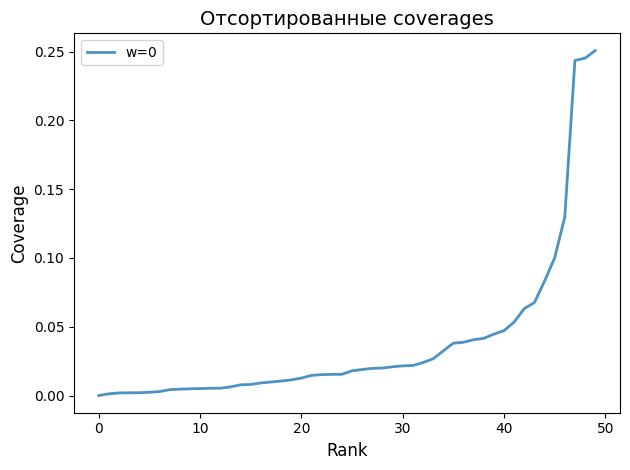

In [92]:
plot_clusters(compare_result['clusters']['instructor_llm_instruction_1_hubs_with_top_words']['kmeans_50'], "w=0")

plt.title('Отсортированные coverages', fontsize=14)
plt.xlabel('Rank', fontsize=12)
plt.ylabel('Coverage', fontsize=12)
plt.legend()
plt.tight_layout()
plt.show()

Много примеров, где мелкие темы отделены в хабы. Давайте попробуем взвесить эмбеддинги хабов в зависимости от их размера.

In [93]:
compare_result_w_m1 = compare_clusterings(embeddings,
    clusterizations,
    hubs.labels,
    sample_weight=np.array(hubs.get_sizes(), np.float32)**-1
)
compare_result_w_m05 = compare_clusterings(embeddings,
    clusterizations,
    hubs.labels,
    sample_weight=np.array(hubs.get_sizes(), np.float32)**-0.5
)
compare_result_w_p1 = compare_clusterings(embeddings,
    clusterizations,
    hubs.labels,
    sample_weight=np.array(hubs.get_sizes(), np.float32)**1
)
compare_result_w_p05 = compare_clusterings(embeddings,
    clusterizations,
    hubs.labels,
    sample_weight=np.array(hubs.get_sizes(), np.float32)**0.5
)
compare_result_w_log = compare_clusterings(embeddings,
    clusterizations,
    hubs.labels,
    sample_weight=np.log(np.array(hubs.get_sizes(), np.float32))
)

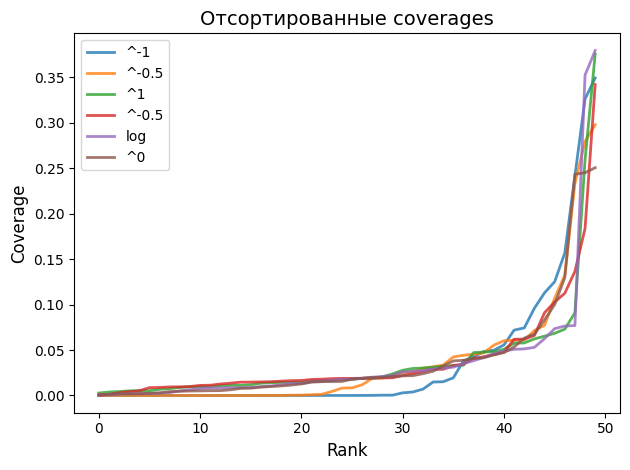

In [94]:
plot_clusters(compare_result_w_m1['clusters']['instructor_llm_instruction_1_hubs_with_top_words']['kmeans_50'], "^-1")
plot_clusters(compare_result_w_m05['clusters']['instructor_llm_instruction_1_hubs_with_top_words']['kmeans_50'], "^-0.5")
plot_clusters(compare_result_w_p1['clusters']['instructor_llm_instruction_1_hubs_with_top_words']['kmeans_50'], "^1")
plot_clusters(compare_result_w_p05['clusters']['instructor_llm_instruction_1_hubs_with_top_words']['kmeans_50'], "^-0.5")
plot_clusters(compare_result_w_log['clusters']['instructor_llm_instruction_1_hubs_with_top_words']['kmeans_50'], "log")
plot_clusters(compare_result['clusters']['instructor_llm_instruction_1_hubs_with_top_words']['kmeans_50'], "^0")

plt.title('Отсортированные coverages', fontsize=14)
plt.xlabel('Rank', fontsize=12)
plt.ylabel('Coverage', fontsize=12)
plt.legend()
plt.tight_layout()
plt.show()

Лучше всего выглядит возведение размеров в 1 степень. Посмотрим какой при этом результат.

In [95]:
print(find_argmax(compare_result_w_p1['accuracy']))

(('instructor_llm_instruction_2_hubs_with_top_words', 'kmeans_75'), 0.819047619047619)


Относительно небольшая жертва качеством ради более равномерного таргета.

In [99]:
print(f"accuracy: {compare_result_w_p1['accuracy']['instructor_llm_instruction_2_hubs_with_top_words']['kmeans_75']}")
print(f"coverage mean: {compare_result_w_p1['coverage_mean']['instructor_llm_instruction_2_hubs_with_top_words']['kmeans_75']}")
print(f"coverage variance: {compare_result_w_p1['coverage_variance']['instructor_llm_instruction_2_hubs_with_top_words']['kmeans_75']}")
print(f"result: {compare_result_w_p1['clusters']['instructor_llm_instruction_2_hubs_with_top_words']['kmeans_75']}")

accuracy: 0.819047619047619
coverage mean: 0.026655719215535674
coverage variance: 0.0008831059347394157
result: defaultdict(<class 'list'>, {62: ['1C', '1c_club', '1c_game_studios', '1c_tools', '1cair', '1p1', '2x', '3dquality', '3dtool', '3rdman', '404HUB', '404fest', '42tasks', '4glaza', 'ActiveCloud', 'AflexDistribution', 'BrandMaker', 'Centrobit', 'Chemistry', 'SECL_GROUP', 'T1Holding', 'Trendvision', 'achiever', 'action360', 'activecloudru', 'acumatica', 'adminvps', 'adobe', 'adv', 'advantshop', 'advocam', 'advodka', 'agima', 'airbnb', 'alfa', 'allmemory', 'allmychanges', 'altegro', 'altegrocloud', 'alternativaplatform', 'altweb', 'ambar', 'amnezia', 'amvera', 'anker_innovations', 'ant', 'antilatency', 'anve', 'anvilgames', 'anylanguage', 'aori', 'apphud', 'appnestic', 'appodeal', 'appsministry', 'apptractor', 'ardoor', 'armisoft', 'arnion', 'arvara', 'ascon', 'astoundcommerce', 'astrio', 'atol', 'autodesk', 'automacon', 'avoapp', 'azimut', 'backendless', 'balrobotov', 'bank24', 

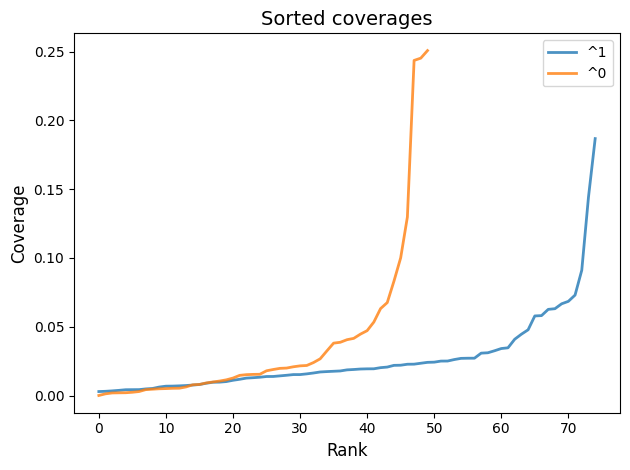

In [101]:
plot_clusters(compare_result_w_p1['clusters']['instructor_llm_instruction_2_hubs_with_top_words']['kmeans_75'], "^1")
plot_clusters(compare_result['clusters']['instructor_llm_instruction_1_hubs_with_top_words']['kmeans_50'], "^0")

plt.title('Sorted coverages', fontsize=14)
plt.xlabel('Rank', fontsize=12)
plt.ylabel('Coverage', fontsize=12)
plt.legend()
plt.tight_layout()
plt.show()

In [105]:
with open(settings.data_dir / 'targets/clusters.json', '+x') as file:
    json.dump(compare_result_w_p1['clusters']['instructor_llm_instruction_1_hubs_with_top_words']['kmeans_75'], file, indent=4)


Получили таргет, обладающий 100% покрытием и состоящий всего из 75 кластеров. 

Дополнительно попробуем выделить топ-55 хабов в отдельные кластера, а остальное - кластеризовать, так модель будет хорошо различать 55 топовых хабов, дающие 75% покрытия, но кроме будет обладать какими-то знаниями о других, более редких хабах.

In [53]:
hubs_sizes = hubs.get_sizes()
top_hubs = [hub for hub, _ in sorted(list(zip(hubs.labels, hubs_sizes)), key=lambda x: x[1], reverse=True)[:55]]
print(f"top 55 hubs: {top_hubs}")

small_hubs = list(filter(lambda x: x not in top_hubs, hubs.labels))
print(f"Other hubs: {small_hubs}")

top 55 hubs: ['closet', 'itcompanies', 'infosecurity', 'programming', 'webdev', 'popular_science', 'javascript', 'gadgets', 'finance', 'business-laws', 'career', 'it-infrastructure', 'hardware', 'sys_admin', 'gamedev', 'python', 'open_source', 'mobile_dev', 'DIY', 'space', 'machine_learning', 'social_networks', 'android_dev', 'i_am_advertising', 'pm', 'algorithms', 'games', 'artificial_intelligence', 'java', 'hr_management', 'futurenow', 'health', 'net', 'soft', 'study', 'ios_dev', 'smartphones', 'network_technologies', 'php', 'linux', 'transport', 'read', 'cpp', 'analysis_design', 'history', 'productpm', 'maths', 'devops', 'cloud_services', 'physics', 'robot', 'bigdata', 'hi', 'dev_management', 'research']
Other hubs: ['1C', '1c', '1c_club', '1c_game_studios', '1c_tools', '1cair', '1cloud', '1p1', '1world', '2035_university', '2can', '2gis', '2pay', '2thhappypm', '2x', '300murlocs', '360totalsecurity', '3cx', '3d-printers', '3d_graphics', '3dprintus', '3dquality', '3dru', '3dtool', '3

In [54]:
embeddings_small = {}

embeddings_small["small_llm_hubs_with_top_words"] = small_llm.encode([build_text(label, hubs_top_words) for label in small_hubs])
empty_instruction_top_words = [build_text(label, hubs_top_words, "") for label in small_hubs]
embeddings_small["instructor_llm_hubs_with_top_words"] = instructor_llm.encode(empty_instruction_top_words)
instruction_1_top_words = [build_text(label, hubs_top_words, "Represent the Programming Hub category for clustering:") for label in small_hubs]
instruction_2_top_words = [build_text(label, hubs_top_words, "Represent the Programming Hub category for company or technology clustering:") for label in small_hubs]
instruction_3_top_words = [build_text(label, hubs_top_words, "Represent the Programming Hub category for company or technology or activity clustering:") for label in small_hubs]
instruction_4_top_words = [build_text(label, hubs_top_words, "Represent the Programming Hub category for company or technology or profession clustering:") for label in small_hubs]

embeddings_small["instructor_llm_instruction_1_hubs_with_top_words"] = instructor_llm.encode(instruction_1_top_words)
embeddings_small["instructor_llm_instruction_2_hubs_with_top_words"] = instructor_llm.encode(instruction_2_top_words)
embeddings_small["instructor_llm_instruction_3_hubs_with_top_words"] = instructor_llm.encode(instruction_3_top_words)
embeddings_small["instructor_llm_instruction_4_hubs_with_top_words"] = instructor_llm.encode(instruction_4_top_words)
embeddings_small["instructor_llm_instruction_4_hubs_with_top_words"] = instructor_llm.encode(instruction_4_top_words)

`SentenceTransformer._target_device` has been deprecated, please use `SentenceTransformer.device` instead.
`SentenceTransformer._target_device` has been deprecated, please use `SentenceTransformer.device` instead.
`SentenceTransformer._target_device` has been deprecated, please use `SentenceTransformer.device` instead.
`SentenceTransformer._target_device` has been deprecated, please use `SentenceTransformer.device` instead.
`SentenceTransformer._target_device` has been deprecated, please use `SentenceTransformer.device` instead.
`SentenceTransformer._target_device` has been deprecated, please use `SentenceTransformer.device` instead.


In [76]:
compare_result_small_w_m1 = compare_clusterings(embeddings_small,
    clusterizations,
    small_hubs,
    sample_weight=np.array(hubs.get_sizes(small_hubs), np.float32)**-1
)
compare_result_small_w_p1 = compare_clusterings(embeddings_small,
    clusterizations,
    small_hubs,
    sample_weight=np.array(hubs.get_sizes(small_hubs), np.float32)**1
)
compare_result_small = compare_clusterings(embeddings_small,
    clusterizations,
    small_hubs,
    sample_weight=np.array(hubs.get_sizes(small_hubs), np.float32)**0
)

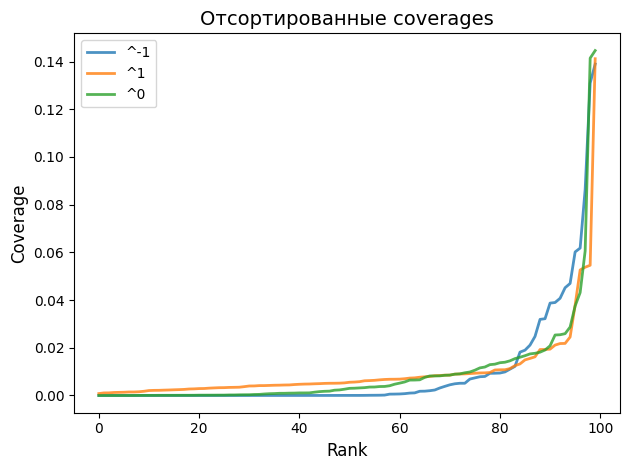

In [79]:
plot_clusters(compare_result_small_w_m1['clusters']['instructor_llm_instruction_1_hubs_with_top_words']['kmeans_100'], "^-1", texts=small_hubs)
plot_clusters(compare_result_small_w_p1['clusters']['instructor_llm_instruction_1_hubs_with_top_words']['kmeans_100'], "^1", texts=small_hubs)
plot_clusters(compare_result_small['clusters']['instructor_llm_instruction_1_hubs_with_top_words']['kmeans_100'], "^0", texts=small_hubs)

plt.title('Отсортированные coverages', fontsize=14)
plt.xlabel('Rank', fontsize=12)
plt.ylabel('Coverage', fontsize=12)
plt.legend()
plt.tight_layout()
plt.show()

In [80]:
print(find_argmax(compare_result_small_w_p1['accuracy']))

(('instructor_llm_instruction_2_hubs_with_top_words', 'kmeans_75'), 0.7428571428571429)


In [ ]:
result = compare_result_small_w_p1['clusters']['instructor_llm_instruction_3_hubs_with_top_words']['kmeans_75']
initial_len = len(result)
for i, top_hub in enumerate(top_hubs):
    result[i + initial_len] = [top_hub]


with open(settings.data_dir / 'targets/clusters_top_separated.json', '+x') as file:
    json.dump(result, file, indent=4)


Таким образом мы получили три варианта таргета:
- топ-150 хабов, обладающие покрытием чуть меньше 90%
    * [+] такой подход скорее всего даст наилучшее качество на классификации топовых лейблов
    * [-] модель не будет знать ничего про существование остальных 1900+ хабов
- 75 кластеров, обеспечивающие 100% покрытие
    * [+] абсолютное покрытие
    * [-] самые крупные лейблы смешанны в кластерах, качество на них вероятно будет хуже, чем в первом подходе. 
- mixed решение: 55 хабов выделенные в "персональные кластера" и остальные хабы разбитые на 75 кластеров
    * [+] комбинируются плюсы от обоих подходов: абсолютное покрытие и вероятно, хорошее качество на топе
    * [-] пока не знаю, увидим когда будем обучаться

